Eric's attempt

In [1]:
# Imports
import icepyx as ipx
import s3fs
import h5py
import numpy as np

**Cloud Accessed ATL03 data from icepyx docs**

In [2]:
# bounding box
# "producerGranuleId": "ATL03_20191130221008_09930503_004_01.h5",
short_name = 'ATL03'
spatial_extent = [-45, 58, -35, 75]
date_range = ['2019-11-30','2019-11-30']
reg=ipx.Query(short_name, spatial_extent, date_range)

In [3]:
gran_ids = reg.avail_granules(ids=True, s3urls=True)
gran_ids

C:\Users\zfair\Anaconda3\lib\site-packages\icepyx\core\granules.py:135: UserWarning: You MUST be pre-authenticated by NSIDC as a beta tester to have cloud access to ICESat-2 data
  warnings.warn(


[['ATL03_20191130112041_09860505_005_01.h5',
  'ATL03_20191130112606_09860506_005_01.h5',
  'ATL03_20191130220138_09930502_005_01.h5',
  'ATL03_20191130221008_09930503_005_01.h5'],
 ['s3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130112041_09860505_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130112606_09860506_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130220138_09930502_005_01.h5',
  's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/005/2019/11/30/ATL03_20191130221008_09930503_005_01.h5']]

In [5]:
reg.earthdata_login("icepyx_dev","icepyx_dev@gmail.com", s3token=True)

AssertionError: You must be working from a valid AWS instance to use s3 data access

In [5]:
credentials = reg._s3login_credentials

In [6]:
s3 = s3fs.S3FileSystem(key=credentials['accessKeyId'],
                       secret=credentials['secretAccessKey'],
                       token=credentials['sessionToken'])

In [7]:
s3url = gran_ids[1][0]

In [8]:
%time f = h5py.File(s3.open(s3url,'rb'),'r')

CPU times: user 59 ms, sys: 27.3 ms, total: 86.3 ms
Wall time: 251 ms


/srv/conda/envs/notebook/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7f11e86a3d00>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


****First crack at a beam subset function**** This successfully extracts the orientation, however, I don't know how to actually subset the dataset based on the beam names.

In [ ]:
def subsetBeams(dataset, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = dataset['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            dset = dataset['gt1l', 'gt2l', 'gt3l'] ## This subset method DOES NOT WORK
            return dset
        elif orientation == 1:
            dset = dataset['gt1r', 'gt2r', 'gt3r']
            return dset
        else:
            print("Error: transition phase")
    elif strength == 'weak':
        if orientation == 0:
            dset = dataset['gt1r', 'gt2r', 'gt3r']
            return dset
        elif orientation == 1:
            dset = dataset['gt1l', 'gt2l', 'gt3l']
            return dset
        else:
            print("Error: transition phase")
    else:
        print("Error: invalid strength input")

In [21]:
def subsetBeamsv2(f, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = f['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            strong_left = pd.DataFrame(data={'lat': f['gt1l/heights/lat_ph'][:],
                                            'lon': f['gt1l/heights/lon_ph'][:],
                                            'elev': f['gt1l/heights/h_ph'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2l/heights/lat_ph'][:],
                                                'lon': f['gt2l/heights/lon_ph'][:],
                                                'elev': f['gt2l/heights/h_ph'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3l/heights/lat_ph'][:],
                                            'lon': f['gt3l/heights/lon_ph'][:],
                                            'elev': f['gt3l/heights/h_ph'][:]})
            
        elif orientation == 1:
            strong_left = pd.DataFrame(data={'lat': f['gt1r/heights/lat_ph'][:],
                                            'lon': f['gt1r/heights/lon_ph'][:],
                                            'elev': f['gt1r/heights/h_ph'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2r/heights/lat_ph'][:],
                                            'lon': f['gt2r/heights/lon_ph'][:],
                                            'elev': f['gt2r/heights/h_ph'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3r/heights/lat_ph'][:],
                                            'lon': f['gt3r/heights/lon_ph'][:],
                                            'elev': f['gt3r/heights/h_ph'][:]})
            
        else:
            print('Error: invalid strength input')
            
        return strong_left, strong_central, strong_right

In [22]:
f = h5py.File('C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/is2/processed_ATL03_20190904170648_10480405_004_01.h5', 'r')

strong_left,strong_central,strong_right = subsetBeamsv2(f, 'strong')

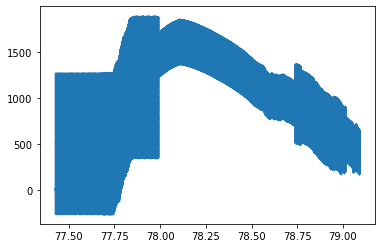

In [23]:
plt.plot(strong_left['lat'], strong_left['elev'], '.', markersize=0.2)
plt.show()